In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import matplotlib.animation as ani
from IPython.display import HTML
import time
import torch.nn.functional as F
import torchvision.models as models
from scipy import linalg
import pandas as pd


In [85]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

LEARNING_RATE = 5e-5
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64
FEATURES_GEN = 64
BETA = 0.5


Device: cuda


In [86]:
import os
os.makedirs('Desktop/Results', exist_ok=True)
os.makedirs('Desktop/Models', exist_ok=True)


In [87]:
dataset = datasets.CIFAR10(root="Desktop/dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


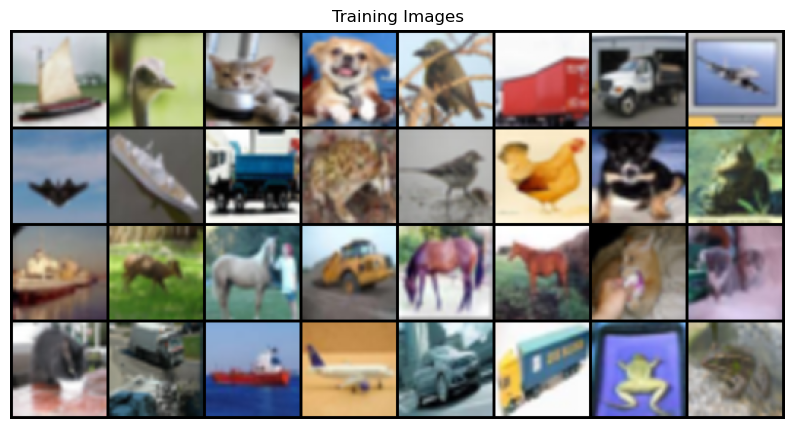

In [88]:
import torchvision.utils as vutils

real_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(), (1, 2, 0)))


In [89]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()
        self.model = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # Applying custom block layers
            self._build_block(features_d, features_d * 2, 4, 2, 1),  # Output=128
            self._build_block(features_d * 2, features_d * 4, 4, 2, 1),  # Output=256
            self._build_block(features_d * 4, features_d * 8, 4, 2, 1),  # Output=512
            # Final layer: output 1x1 after Conv2d
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _build_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.model(x)


In [90]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super().__init__()
        self.model = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            # Using Gnet to build the layers
            self._build_block(channels_noise, features_g * 16, 4, 1, 0),  # Output: 4x4
            self._build_block(features_g * 16, features_g * 8, 4, 2, 1),  # Output: 8x8
            self._build_block(features_g * 8, features_g * 4, 4, 2, 1),   # Output: 16x16
            self._build_block(features_g * 4, features_g * 2, 4, 2, 1),   # Output: 32x32
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _build_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.model(x)


In [91]:
def initialize_weights(model):
    # Initialize weights following the DCGAN paper
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(module.weight.data, mean=0.0, std=0.02)


In [92]:
# Initialize generator and discriminator
generator = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
discriminator = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

# Apply weight initialization
initialize_weights(generator)
initialize_weights(discriminator)


In [93]:
# Ensure 'beta' is defined
beta = 0.5  # or whatever value you intended

# Optimizers for generator and discriminator
optimizer_generator = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(beta, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(beta, 0.999))

# Loss function
loss_criterion = nn.BCELoss()

# Fixed noise for visualization
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)  # 32 works better for DCGAN
current_step = 0


In [94]:
generator.train(),discriminator.train()


(Generator(
   (model): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4):

In [95]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Default block index to return, corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to corresponding output block indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling features
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super().__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        inception = models.inception_v3(pretrained=True)

        # Block 0: Input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: Maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: Maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: Aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        # Set requires_grad for all parameters
        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        # Resize input if needed
        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        # Normalize input if needed
        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        # Process the input through the blocks and collect outputs
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

# Select the block index corresponding to 2048-dimensional features
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
# Create the model with the selected block index
model = InceptionV3([block_idx])
# Move the model to GPU
model = model.cuda()


/home/vmunaga/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vmunaga/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [96]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()  # Set model to evaluation mode
    activations = np.empty((len(images), dims))  # Initialize activation array
    
    # Move images to GPU if cuda is True
    if cuda:
        batch = images.cuda()
    else:
        batch = images
    
    # Get activations from the model
    pred = model(batch)[0]
    
    # Ensure the output has the correct dimensions (1x1)
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    # Reshape activations to 2D (samples x features)
    activations = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    # Calculate mean and covariance of the activations
    mean = np.mean(activations, axis=0)
    covariance = np.cov(activations, rowvar=False)
    
    return mean, covariance


In [97]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    # Ensure the mean vectors and covariance matrices are in the correct format
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    # Check that the mean vectors and covariance matrices have the same dimensions
    assert mu1.shape == mu2.shape, 'Mean vectors have different lengths between training and test.'
    assert sigma1.shape == sigma2.shape, 'Covariance matrices have different dimensions between training and test.'

    # Compute the difference between the means
    mean_diff = mu1 - mu2

    # Compute the square root of the product of the covariance matrices
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    # If the result is not finite, add a small epsilon to the diagonal of the covariance matrices
    if not np.isfinite(covmean).all():
        print(f'FID calculation produces singular product; adding {eps} to diagonal of covariance estimates')
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # If the result has complex components, discard them (assuming they are small)
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError(f'Imaginary component found: {np.max(np.abs(covmean.imag))}')
        covmean = covmean.real

    # Trace of the square root of the product of covariance matrices
    tr_covmean = np.trace(covmean)

    # Calculate and return the Frechet Inception Distance
    return (mean_diff.dot(mean_diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)


In [98]:
def calculate_frechet(images_real, images_fake, model):
    # Calculate activation statistics for real and fake images
    mu_real, std_real = calculate_activation_statistics(images_real, model, cuda=True)
    mu_fake, std_fake = calculate_activation_statistics(images_fake, model, cuda=True)
    
    # Compute and return the Frechet Inception Distance (FID)
    fid_score = calculate_frechet_distance(mu_real, std_real, mu_fake, std_fake)
    
    return fid_score


In [99]:
# Initialize loss lists, image list, and FID list
import torchvision.utils as utils
generator_losses = []
discriminator_losses = []
generated_images = []
fid_scores = []
iteration = 0

print("!!Training Started!!")

# Start the timer
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch += 1
    
    for batch_idx, (real_images, _) in enumerate(dataloader, 0):
        # Move real images to device
        real_images = real_images.to(device)
        
        # Generate noise and fake images
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake_images = generator(noise)  # Generator generates fake image data

        # Train the Discriminator: max log(D(x)) + log(1 - D(G(z)))
        real_pred = disc(real_images).reshape(-1)
        loss_real = loss_criterion(real_pred, torch.ones_like(real_pred))
        fake_pred = disc(fake_images.detach()).reshape(-1)
        loss_fake = loss_criterion(fake_pred, torch.zeros_like(fake_pred))
        loss_disc = (loss_real + loss_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        optimizer_discriminator.step()

        # Train the Generator: min log(1 - D(G(z))) <-> max log(D(G(z)))
        gen_pred = disc(fake_images).reshape(-1)
        loss_gen = loss_criterion(gen_pred, torch.ones_like(gen_pred))
        gen.zero_grad()
        loss_gen.backward()
        optimizer_generator.step()

        # Record losses
        generator_losses.append(loss_gen.detach().cpu())
        discriminator_losses.append(loss_disc.detach().cpu())

        # Check the generator's progress by saving images of fixed_noise
        if (iteration % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader) - 1)):
            with torch.no_grad():
                fixed_fake_images = gen(fixed_noise).detach().cpu()
            generated_images.append(utils.make_grid(fixed_fake_images, padding=2, normalize=True))

        iteration += 1

    # Calculate FID for the current epoch
    fid_distance = calculate_frechet(real_images, fake_images, model)
    fid_scores.append(fid_distance)

    # Print loss and FID every 5 epochs
    if epoch % 5 == 0:
        print(f'\nEpoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                Loss Discriminator: {loss_disc:.3f}, Loss Generator: {loss_gen:.3f}, FID: {fid_distance:.3f}')

    # Save generated images for the current epoch
    generated_images_batch = gen(fixed_noise)
    if not os.path.exists('Desktop/Results/DCGAN_FAKE'):
        os.makedirs('Desktop/Results/DCGAN_FAKE')
    if not os.path.exists('Desktop/Results/DCGAN_REAL'):
        os.makedirs('Desktop/Results/DCGAN_REAL')

    utils.save_image(generated_images_batch.detach(), f'Desktop/Results/DCGAN_FAKE/DCGAN50_epoch_{epoch:03d}.png', normalize=True)

    # Save real images for the current epoch
    utils.save_image(real_images.detach(), f'Desktop/Results/DCGAN_REAL/DCGAN50_epoch_{epoch:03d}.png', normalize=True)

# End timing
end_time = time.time()
print(f'\n\nElapsed time: {end_time - start_time:.2f} seconds.')


!!Training Started!!

Epoch [5/40] Batch 390/391                 Loss Discriminator: 1.724, Loss Generator: 0.066, FID: 485.639

Epoch [10/40] Batch 390/391                 Loss Discriminator: 1.838, Loss Generator: 0.052, FID: 499.362

Epoch [15/40] Batch 390/391                 Loss Discriminator: 1.852, Loss Generator: 0.051, FID: 483.070

Epoch [20/40] Batch 390/391                 Loss Discriminator: 1.854, Loss Generator: 0.050, FID: 486.539

Epoch [25/40] Batch 390/391                 Loss Discriminator: 1.855, Loss Generator: 0.050, FID: 476.934

Epoch [30/40] Batch 390/391                 Loss Discriminator: 1.853, Loss Generator: 0.050, FID: 468.622

Epoch [35/40] Batch 390/391                 Loss Discriminator: 1.853, Loss Generator: 0.051, FID: 475.601

Epoch [40/40] Batch 390/391                 Loss Discriminator: 1.852, Loss Generator: 0.051, FID: 489.370


Elapsed time: 851.38 seconds.


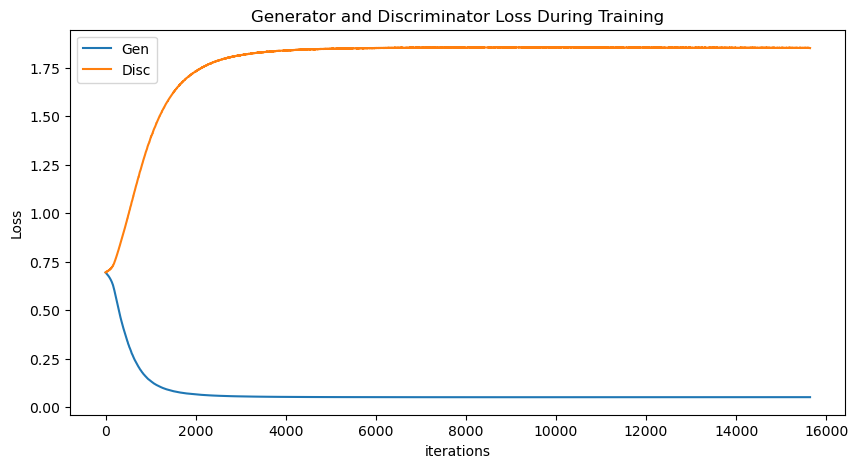

In [100]:
if not os.path.exists('Desktop/Results/Loss_Data'):
       os.makedirs('Desktop/Results/Loss_Data')
np.save('Desktop/Results/Loss_Data/DCGAN_GLoss', generator_losses) 
np.save('Desktop/Results/Loss_Data/DCGAN_DLoss', discriminator_losses) 
generator_losses = np.load('Desktop/Results/Loss_Data/DCGAN_GLoss.npy')
discriminator_losses = np.load('Desktop/Results/Loss_Data/DCGAN_DLoss.npy')
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses,label="Gen")
plt.plot(discriminator_losses,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Desktop/Results/loss.pdf',
            format='pdf',
            bbox_inches='tight')
plt.show()

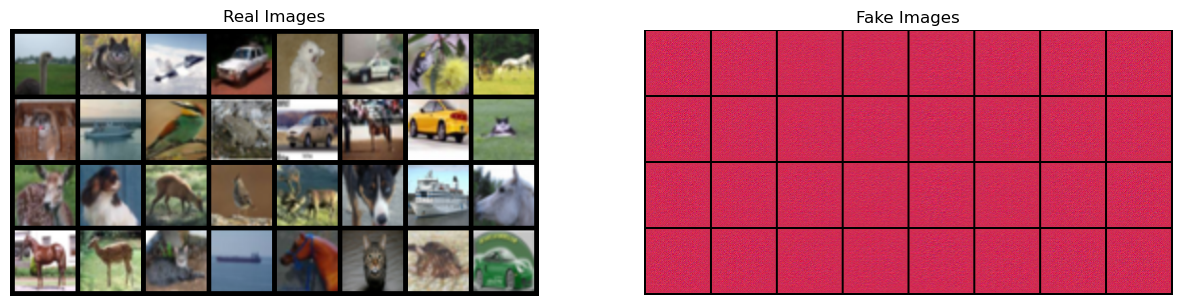

In [101]:
# Retrieve a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Create a figure for displaying the real and fake images
plt.figure(figsize=(15, 15))

# Display the real images
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
real_images_grid = np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(), (1, 2, 0))
plt.imshow(real_images_grid)

# Display the most recent fake images
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
fake_images_grid = np.transpose(generated_images[-1], (1, 2, 0))
plt.imshow(fake_images_grid)

# Save the figure to a PDF file
plt.savefig('Desktop/Results/DCGAN30_BEST_FAKE_32.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


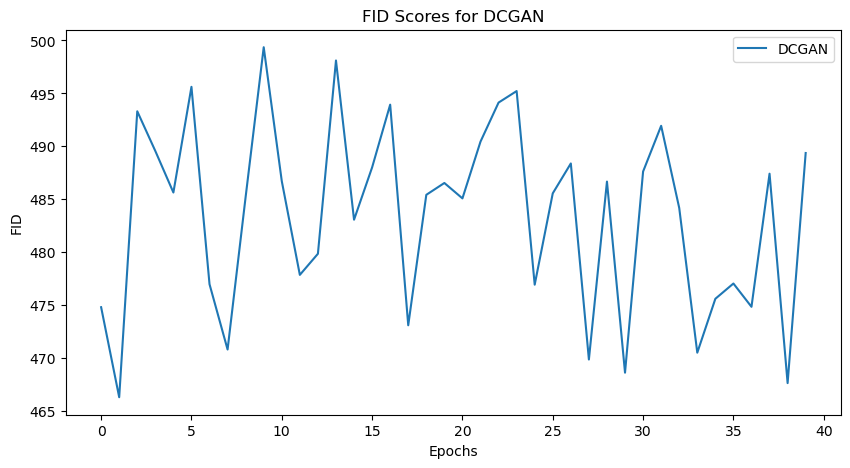

In [102]:
# Create a figure for plotting FID scores
plt.figure(figsize=(10, 5))

# Set the title for the plot
plt.title("FID Scores for DCGAN")

# Plot the FID scores over epochs
plt.plot(fid_scores, label="DCGAN")

# Label the x and y axes
plt.xlabel("Epochs")
plt.ylabel("FID")

# Display the legend
plt.legend()

# Save the plot to a PDF file
plt.savefig('Desktop/Results/FID.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [103]:
# Check if the directory 'Results/FID_score' exists, if not, create it
if not os.path.exists('Desktop/Results/FID_score'):
    os.makedirs('Desktop/Results/FID_score')

# Save the FID scores to a file
np.save('Desktop/Results/FID_score/DC_FID', fid_scores)


In [104]:
np.average(generator_losses), np.average(discriminator_losses), np.min(generator_losses), np.min(discriminator_losses), generator_losses[-1], discriminator_losses[-1]


(0.07423894, 1.7758867, 0.050340667, 0.6941401, 0.050655898, 1.8515763)

In [105]:
np.min(fid_scores), np.max(fid_scores), np.mean(fid_scores), fid_scores[-1]


(466.303693760137, 499.3616195903037, 483.4329022992709, 489.3700700431214)